<hr>

# MTG FCI FIR Active Fire Monitoring 

### Data used

| Product Description  | Data Store collection ID| Product Navigator |
|:--------------------:|:-----------------------:|:-----------------:|
| Active Fire Monitoring (netCDF) - MTG - 0 degree | EO:EUM:DAT:0682 | [link](https://vdata.eumetsat.int/product/EO:EUM:DAT:0682) |
| FCI Level 1c Normal Resolution Image Data - MTG - 0 degree | EO:EUM:DAT:0662 | [link](https://vdata.eumetsat.int/product/EO:EUM:DAT:0662) |


This notebook demonstrates how to access, load, and visualise the [Active Fire Monitoring product (FIR)](https://vdata.eumetsat.int/product/EO:EUM:DAT:0682) product derived from Meteosat Third Generation (MTG) geostationary imager data. The FIR product detects and characterises active fires within pixels using the FCI IR-3.8 μm channel, which is highly sensitive to fire hotspots.

In addition, [FCI Level 1c Normal Resolution Image Data](https://vdata.eumetsat.int/product/EO:EUM:DAT:0662) consists of a set of files that contain the level 1c science data rectified to a reference grid together with the auxiliary data associated with the processing configuration and the quality assessment of the dataset.

As a case study, this notebook explores the Iberian Pennisula wildfires of summer 2025, combining FIR datasets with True Colour RGB composites to illustrate fire monitoring capabilities under varying conditions of cloud cover and surface features.

This module has the following outline:
* [1 - Data Store access with EUMDAC](#access)
* [2 - Load and visualize Active Fire Monitoring (FIR) data](#fir)
* [3 - Load and visualize FCI Level 1c Normal Resolution Image Data](#rgb)
* [4 - Compare FIR data with RGB composites](#compare)


#### Load required libraries

In [1]:
import eumdac
import datetime
import shutil
import fnmatch
import requests
import time
import os
import zipfile
import json
import os
import re
import numpy as np
from shapely.wkt import loads
from shapely.geometry import Polygon, LineString
from pathlib import Path
import getpass
import cartopy.crs as ccrs
import glob

import satpy
from satpy.scene import Scene
from satpy import find_files_and_readers
from satpy.writers import get_enhanced_image

import warnings
from cartopy.io import DownloadWarning
import xarray as xr

import credentials

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DownloadWarning)

from pyproj import Proj
from pyproj import CRS
from pyresample.geometry import AreaDefinition
from pyresample import get_area_def

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

download_dir = os.path.join(os.getcwd(), "products/MTG")
os.makedirs(download_dir, exist_ok=True)

/tmp/ipykernel_3727955/2505168746.py:23: UserWarning: 'satpy.writers.get_enhanced_image' has been moved to 'satpy.enhancements.enhancer.get_enhanced_image'. Import from the new location instead (ex. 'from satpy.enhancements.enhancer import get_enhanced_image'). The old import paths will be removed in Satpy 1.0
  from satpy.writers import get_enhanced_image


#### Set variables

In [2]:
latmin = 37.0000
latmax= 43.7914
lonmin= -9.5600
lonmax= 3.3322

## Data Store access and download with EUMDAC

<div class="alert alert-block alert-success">
<b>NOTE:</b><br />
Before running this section, remember to edit the credentials.py file with your personal API credentials for EUMDAC. You can find your personal API credentials here: <a href="https://api.eumetsat.int/api-key/">https://api.eumetsat.int/api-key/</a>
</div>

FYI: MTG products follow the WMO file naming convention. You can find more information about this in our User Portal guide: <a href="https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention">https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide#ID-Naming-convention</a>
</div>

In [3]:
from download_from_archive import download_from_eumdac
import credentials

# geographical bounds of search area
lonlat_bbox = [lonmin, latmin, lonmax, latmax]
# lonlat_bbox = None

output_folder = "products/"
run_name = ""

# start_time = "2025-08-18T16:00:00"
# end_time = "2025-08-18T16:10:00"
start_time = "2025-08-18T22:20:00"
end_time = "2025-08-18T22:30:00"

collection_ids = [
    "EO:EUM:DAT:0682"
]

file_endings = ['.nc']

download_from_eumdac(start_time, end_time, collection_ids, file_endings,
                     lonlat_bbox, output_folder, run_name,
                     credentials.EUMDAC_CONSUMER_KEY, credentials.EUMDAC_CONSUMER_SECRET)

[2025-09-19 15:18:28] [DEBUG] download_fci_from_archive: DataStore initialized.
[2025-09-19 15:18:34] [INFO] download_fci_from_archive: Found 1 products for collection_id EO:EUM:DAT:0682 with type MTIFCI2FIR and time range 2025-08-18 22:20:01 to 2025-08-18 22:29:59 (adjusted for L2).
[2025-09-19 15:18:34] [INFO] download_fci_from_archive: File already exists, skipping download: products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-2-FIR--FD------NC4E_C_EUMT_20250818223534_L2PF_OPE_20250818222000_20250818223000_N__C_0135_0000.nc
[2025-09-19 15:18:35] [INFO] download_fci_from_archive: No files to download for collection EO:EUM:DAT:0682.


## FIR Product Processing

Let us open one of the Active Fire Monitoring products using `Scene` from `satpy` library, and inspect it using the function `available_dataset_names`.

The product provides two main datasets at 2 km nadir resolution:
* `Fire Probability` – the likelihood of fire presence per pixel.
* `Fire Result` – a categorical indicator derived from fire probability.

In addition, quality indicators (`product_completeness`, `product_quality`, `product_timeliness`) are included for each repeat cycle to support data interpretation. The FIR product is currently based on the heritage SEVIRI algorithm, ensuring continuity with existing fire detection services. While it does not yet exploit the full spatial resolution and additional channels of the FCI, future product updates will enhance detection accuracy and resolution.

The reader used in this case is `fci_l2_nc`.

In [4]:
fir_filenames = glob.glob(os.path.join(output_folder, '*FCI-2-FIR*'))

scn = Scene(filenames=[fir_filenames[0]], reader="fci_l2_nc")
print(scn.available_dataset_names())  # Prints list of available datasets

['fire_probability', 'fire_result', 'product_completeness', 'product_quality', 'product_timeliness']


This cell performs the following steps:
1. Load the fire probability dataset (`fire_probability`) from the Satpy Scene and ensure it is oriented upright.
2. Resample the dataset to the defined Area of Interest (AOI). 
3. Extract the resampled fire probability data and its area definition, which includes projection, shape, and geographic extent.
4. Filter pixels with probability above a threshold (e.g., 0.5) to identify potential fire locations.
5. Convert the filtered array indices to geographic coordinates (longitude and latitude) for mapping or analysis.

In [5]:
from pyresample import create_area_def


def get_local_mercator_area(target_proj, area_extent, resolution):
    x_min, y_min = target_proj.transform_point(area_extent[0], area_extent[1], ccrs.PlateCarree())
    x_max, y_max = target_proj.transform_point(area_extent[2], area_extent[3], ccrs.PlateCarree())

    shape = [int((y_max - y_min) / resolution[0]), int((x_max - x_min) / resolution[1])]

    adef = create_area_def('local_area', target_proj, area_extent=area_extent, units='degrees', shape=shape)

    return adef

In [6]:
dataset = "fire_probability"  # Dataset to load. Other option is "fire_result"
# Load dataset. The upper_right_corner keyword is needed to flip the dataset to "upright" projection
scn.load([dataset], upper_right_corner='NE')

target_proj = ccrs.Mercator()
resolution = 500. #m
AOI = get_local_mercator_area(target_proj, [lonmin, latmin, lonmax, latmax], [resolution, resolution])

scn_resample=scn.resample(AOI)

# Extract dataset from Scene object
fir_prob = scn_resample[dataset]

# Extract area definition with information about projection, dataset shape and area extent
adef = fir_prob.attrs['area']  
print(adef)

# filter fires above a probability threshold. Note that the probability range is 0-1
prob_threshold = 0.5
fires_above_th = np.where(fir_prob > prob_threshold)
print(f"Number of potential fire pixels: {len(fires_above_th[0])}")
# get the corresponding lat-lon:
#lon_filtered, lat_filtered = adef.get_lonlat_from_array_coordinates(fires_above_th[1], fires_above_th[0])

SKIPPING RESAMPLING CHECK 


Area ID: local_area
Description: local_area
Projection: {'ellps': 'WGS84', 'k': '1', 'lon_0': '0', 'no_defs': 'None', 'proj': 'merc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2870
Number of rows: 1980
Area extent: (-1064214.332, 4413389.8887, 370938.8072, 5403637.4821)
Number of potential fire pixels: 12497


Now plot the dataset using `matplotlib.pyplot` and `cartopy`.

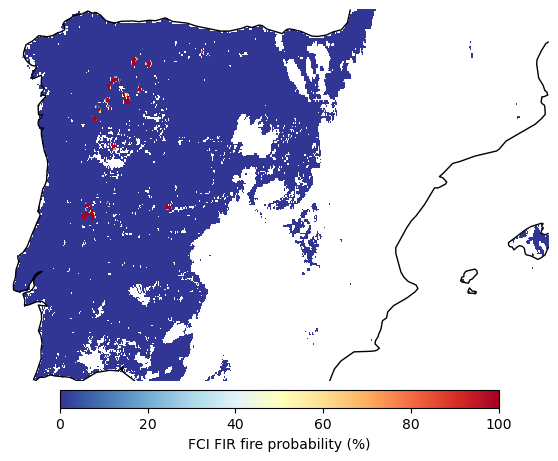

In [7]:
crs = adef.to_cartopy_crs()  # Convert area definition to cartopy CRS object
fig, ax = plt.subplots(subplot_kw={'projection': crs})

ax.coastlines(resolution='50m')

im = ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r', extent=crs.bounds, origin='upper', vmin=0, vmax=100, interpolation='none')
plt.axis('off')
cbar = plt.colorbar(im, orientation='horizontal', aspect=25, shrink=0.72, pad=0.02)
cbar.ax.set_xlabel('FCI FIR fire probability (%)')
plt.tight_layout()
plt.show()

This cell performs the following steps:
1. Select and load the fire detection result dataset (`fire_result`) from the Satpy Scene, ensuring the projection is upright.
2. Resample the dataset to the defined Region of Interest (ROI).
3. Extract the resampled data and its area definition, which includes projection, shape, and geographic extent.
4. Compute the longitude and latitude coordinates for array indices, enabling mapping or further geospatial analysis.

In [8]:
dataset = "fire_result"  # Dataset to load. 
# Load dataset. The upper_right_corner keyword is needed to flip the dataset to "upright" projection
scn.load([dataset], upper_right_corner='NE')

scn_resample=scn.resample(adef)

fir_res = scn_resample[dataset]

# Extract area definition with information about projection, dataset shape and area extent
res = fir_res.attrs['area']  
print(res)

#lon_filtered, lat_filtered = res.get_lonlat_from_array_coordinates(fir_res[1], fir_res[0])

SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


Area ID: local_area
Description: local_area
Projection: {'ellps': 'WGS84', 'k': '1', 'lon_0': '0', 'no_defs': 'None', 'proj': 'merc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2870
Number of rows: 1980
Area extent: (-1064214.332, 4413389.8887, 370938.8072, 5403637.4821)


Now plot the dataset using `matplotlib.pyplot` and `cartopy`. In this case the labels are categorical (discrete) classes, not continuous values. Each pixel in the map belongs to exactly one of the categories.

Since they are discrete classification results, they are represented with a ListedColormap (one distinct color per class) and BoundaryNorm to map the integer values to the correct color interval.

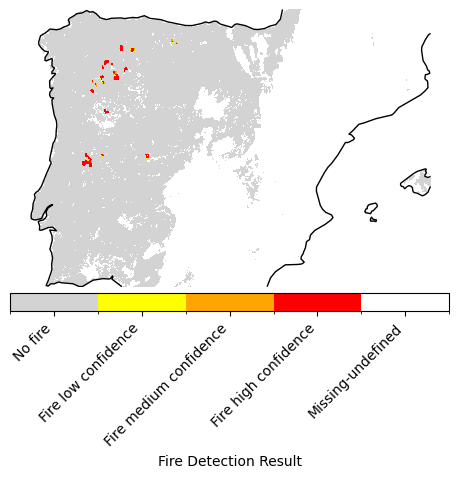

In [9]:
result_labels = {
    0: 'No fire',
    1: 'Fire low confidence',
    2: 'Fire medium confidence',
    3: 'Fire high confidence',
    4: 'Missing-undefined'
}

colors = ['lightgray', 'yellow', 'orange', 'red', 'white']
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5]  # for 5 classes
norm = BoundaryNorm(bounds, cmap.N)

# Plot
crs = adef.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs})

ax.coastlines(resolution='50m')
im = ax.imshow(fir_res, transform=crs, cmap=cmap, norm=norm, extent=crs.bounds, origin='upper', interpolation='nearest')

plt.axis('off')
cbar = plt.colorbar(im, orientation='horizontal', aspect=25, shrink=0.72, pad=0.02, ticks=[0.5, 1.5, 2.5, 3.5, 4.5])
labels = [result_labels[i] for i in range(5)]
cbar.ax.set_xticklabels(labels)
cbar.ax.set_xticklabels(labels, rotation=45, ha='right')
cbar.ax.set_xlabel('Fire Detection Result')

plt.tight_layout()
plt.show()

## 3 - Load and visualise FCI Level 1c Normal Resolution Image Data - MTG - 0 degree

In the next step we will point to the data location and load desired data using the Scene module from Satpy.

The Python package [satpy](https://satpy.readthedocs.io/en/stable/) supports reading and loading data from many input files. For `MTG FCI data in netcdf format` you can use the reader `fci_l1c_nc`. 

In [10]:
download_from_eumdac(start_time, end_time, ["EO:EUM:DAT:0662","EO:EUM:DAT:0665"], file_endings,
                     lonlat_bbox, output_folder, run_name,
                     credentials.EUMDAC_CONSUMER_KEY, credentials.EUMDAC_CONSUMER_SECRET)


[2025-09-19 15:18:56] [DEBUG] download_fci_from_archive: DataStore initialized.
[2025-09-19 15:18:56] [INFO] download_fci_from_archive: Found 1 products for collection_id EO:EUM:DAT:0662 with type MTIFCI1CRRADFDHSI and time range 2025-08-18 22:20:00 to 2025-08-18 22:30:00.
[2025-09-19 15:18:57] [INFO] download_fci_from_archive: Found 1 products for collection_id EO:EUM:DAT:0665 with type MTIFCI1CRRADHRFI and time range 2025-08-18 22:20:00 to 2025-08-18 22:30:00.
[2025-09-19 15:18:58] [INFO] download_fci_from_archive: Will be retrieving chunks: [34, 35]
[2025-09-19 15:18:58] [INFO] download_fci_from_archive: File products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250818223052_IDPFI_OPE_20250818222810_20250818222857_N__O_0135_0035.nc already exists, skipping download.
[2025-09-19 15:18:58] [INFO] download_fci_from_archive: File products/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20250818223039_IDPFI_OPE_2025

You can now use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library to load the data files. Once loaded, a `Scene` object represents a single geographic region of data.

In [11]:
fci_files = find_files_and_readers(base_dir=output_folder, reader='fci_l1c_nc', start_time=datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S"), end_time=datetime.datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%S"))
scn = Scene(filenames=fci_files, reader='fci_l1c_nc')

Here you will be able to select the channel/RGB composite you want to display. You can browse the pre-defined composites using the Satpy function `scn.available_composite_names()`.

We choose to display a True Color RBG:

In [12]:
ch='true_color'
scn.load([ch], upper_right_corner='NE', pad_data=False)

/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/array/core.py:778: FutureWarning: The `token=` keyword to `map_blocks` has been moved to `name=`. Please use `name=` instead as the `token=` keyword will be removed in a future release.
  warnings.warn(
The following datasets were not created and may require resampling to be generated: DataID(name='true_color')


Next, you can use the area definition above in order to resample the loaded Scene object. You can use the function `resample()` to do so.
Let us also save in `xr_color` the image for future plotting.

In [13]:
scn_resampled_color = scn.resample(adef)
xr_color = get_enhanced_image(scn_resampled_color["true_color"])
img = np.moveaxis(xr_color.data.to_numpy(), 0, -1)
scn_resampled_color[ch].attrs['area']

SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 




/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/array/core.py:778: FutureWarning: The `token=` keyword to `map_blocks` has been moved to `name=`. Please use `name=` instead as the `token=` keyword will be removed in a future release.
  warnings.warn(
/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/array/core.py:778: FutureWarning: The `token=` keyword to `map_blocks` has been moved to `name=`. Please use `name=` instead as the `token=` keyword will be removed in a future release.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/pyresample/static/html/icons_svg_inline.html'

Area ID: local_area
Description: local_area
Projection: {'ellps': 'WGS84', 'k': '1', 'lon_0': '0', 'no_defs': 'None', 'proj': 'merc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2870
Number of rows: 1980
Area extent: (-1064214.332, 4413389.8887, 370938.8072, 5403637.4821)

You can now print the metadata of the loaded image

In [14]:
print(scn_resampled_color)

<xarray.DataArray 'where-b2a845b9bd1e90892f38291c29db7734' (bands: 3, y: 1980,
                                                            x: 2870)> Size: 68MB
dask.array<where, shape=(3, 1980, 2870), dtype=float32, chunksize=(1, 1980, 2870), chunktype=numpy.ndarray>
Coordinates:
    crs      object 8B PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Unknown...
  * y        (y) float64 16kB 5.403e+06 5.403e+06 ... 4.414e+06 4.414e+06
  * x        (x) float64 23kB -1.064e+06 -1.063e+06 ... 3.702e+05 3.707e+05
  * bands    (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/21)
    end_time:                2025-08-18 22:30:00
    platform_name:           Meteosat-12
    coordinates:             y x
    start_time:              2025-08-18 22:20:00
    sensor:                  fci
    standard_name:           true_color
    ...                      ...
    resolution:              500
    _satpy_id:               DataID(name='true_color', resolution=500)
    description:             FCI true color c

Afterwards, you can visualize the resampled `true_color` RGB with the function `show()`.

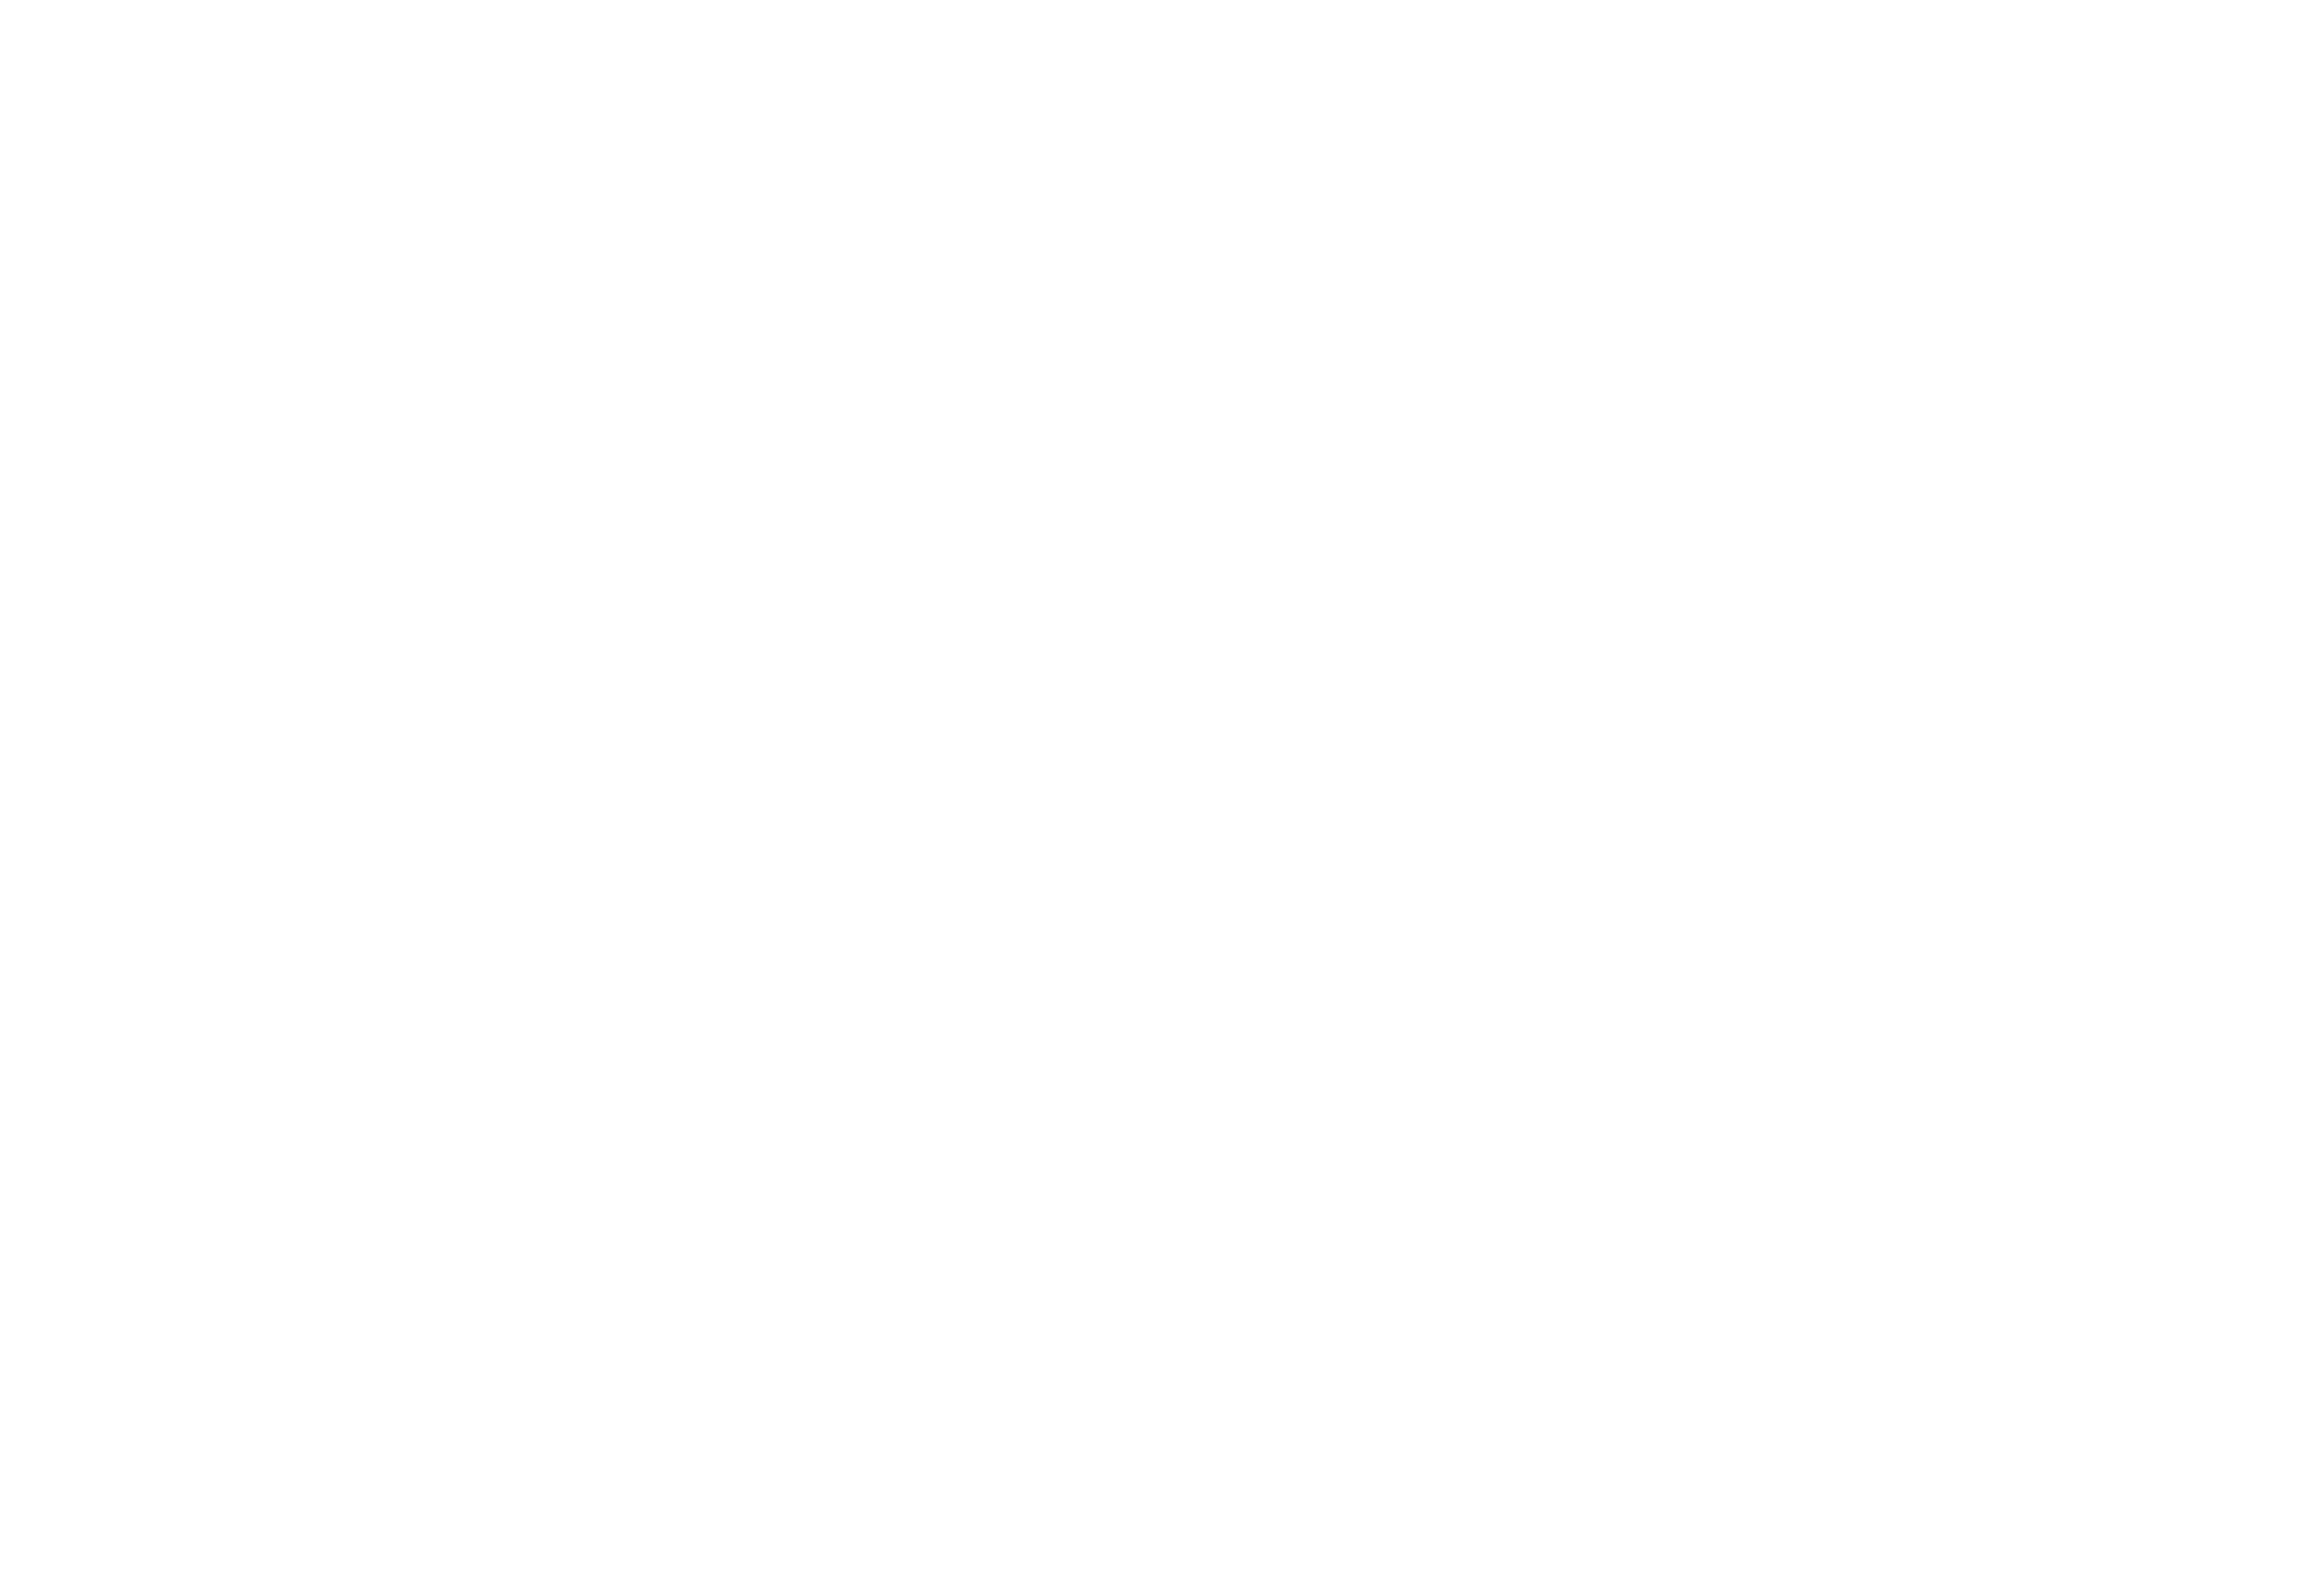

In [15]:
scn_resampled_color.show(ch)

The same thing can be done with channel/RGB composite `fire_temperature`. More informations can be found [here](https://user.eumetsat.int/resources/user-guides/fire-temperature-rgb-quick-guide).

The following datasets were not created and may require resampling to be generated: DataID(name='true_color'), DataID(name='fire_temperature')


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 


SKIPPING RESAMPLING CHECK 




/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/array/core.py:778: FutureWarning: The `token=` keyword to `map_blocks` has been moved to `name=`. Please use `name=` instead as the `token=` keyword will be removed in a future release.
  warnings.warn(
/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/array/core.py:778: FutureWarning: The `token=` keyword to `map_blocks` has been moved to `name=`. Please use `name=` instead as the `token=` keyword will be removed in a future release.
  warnings.warn(


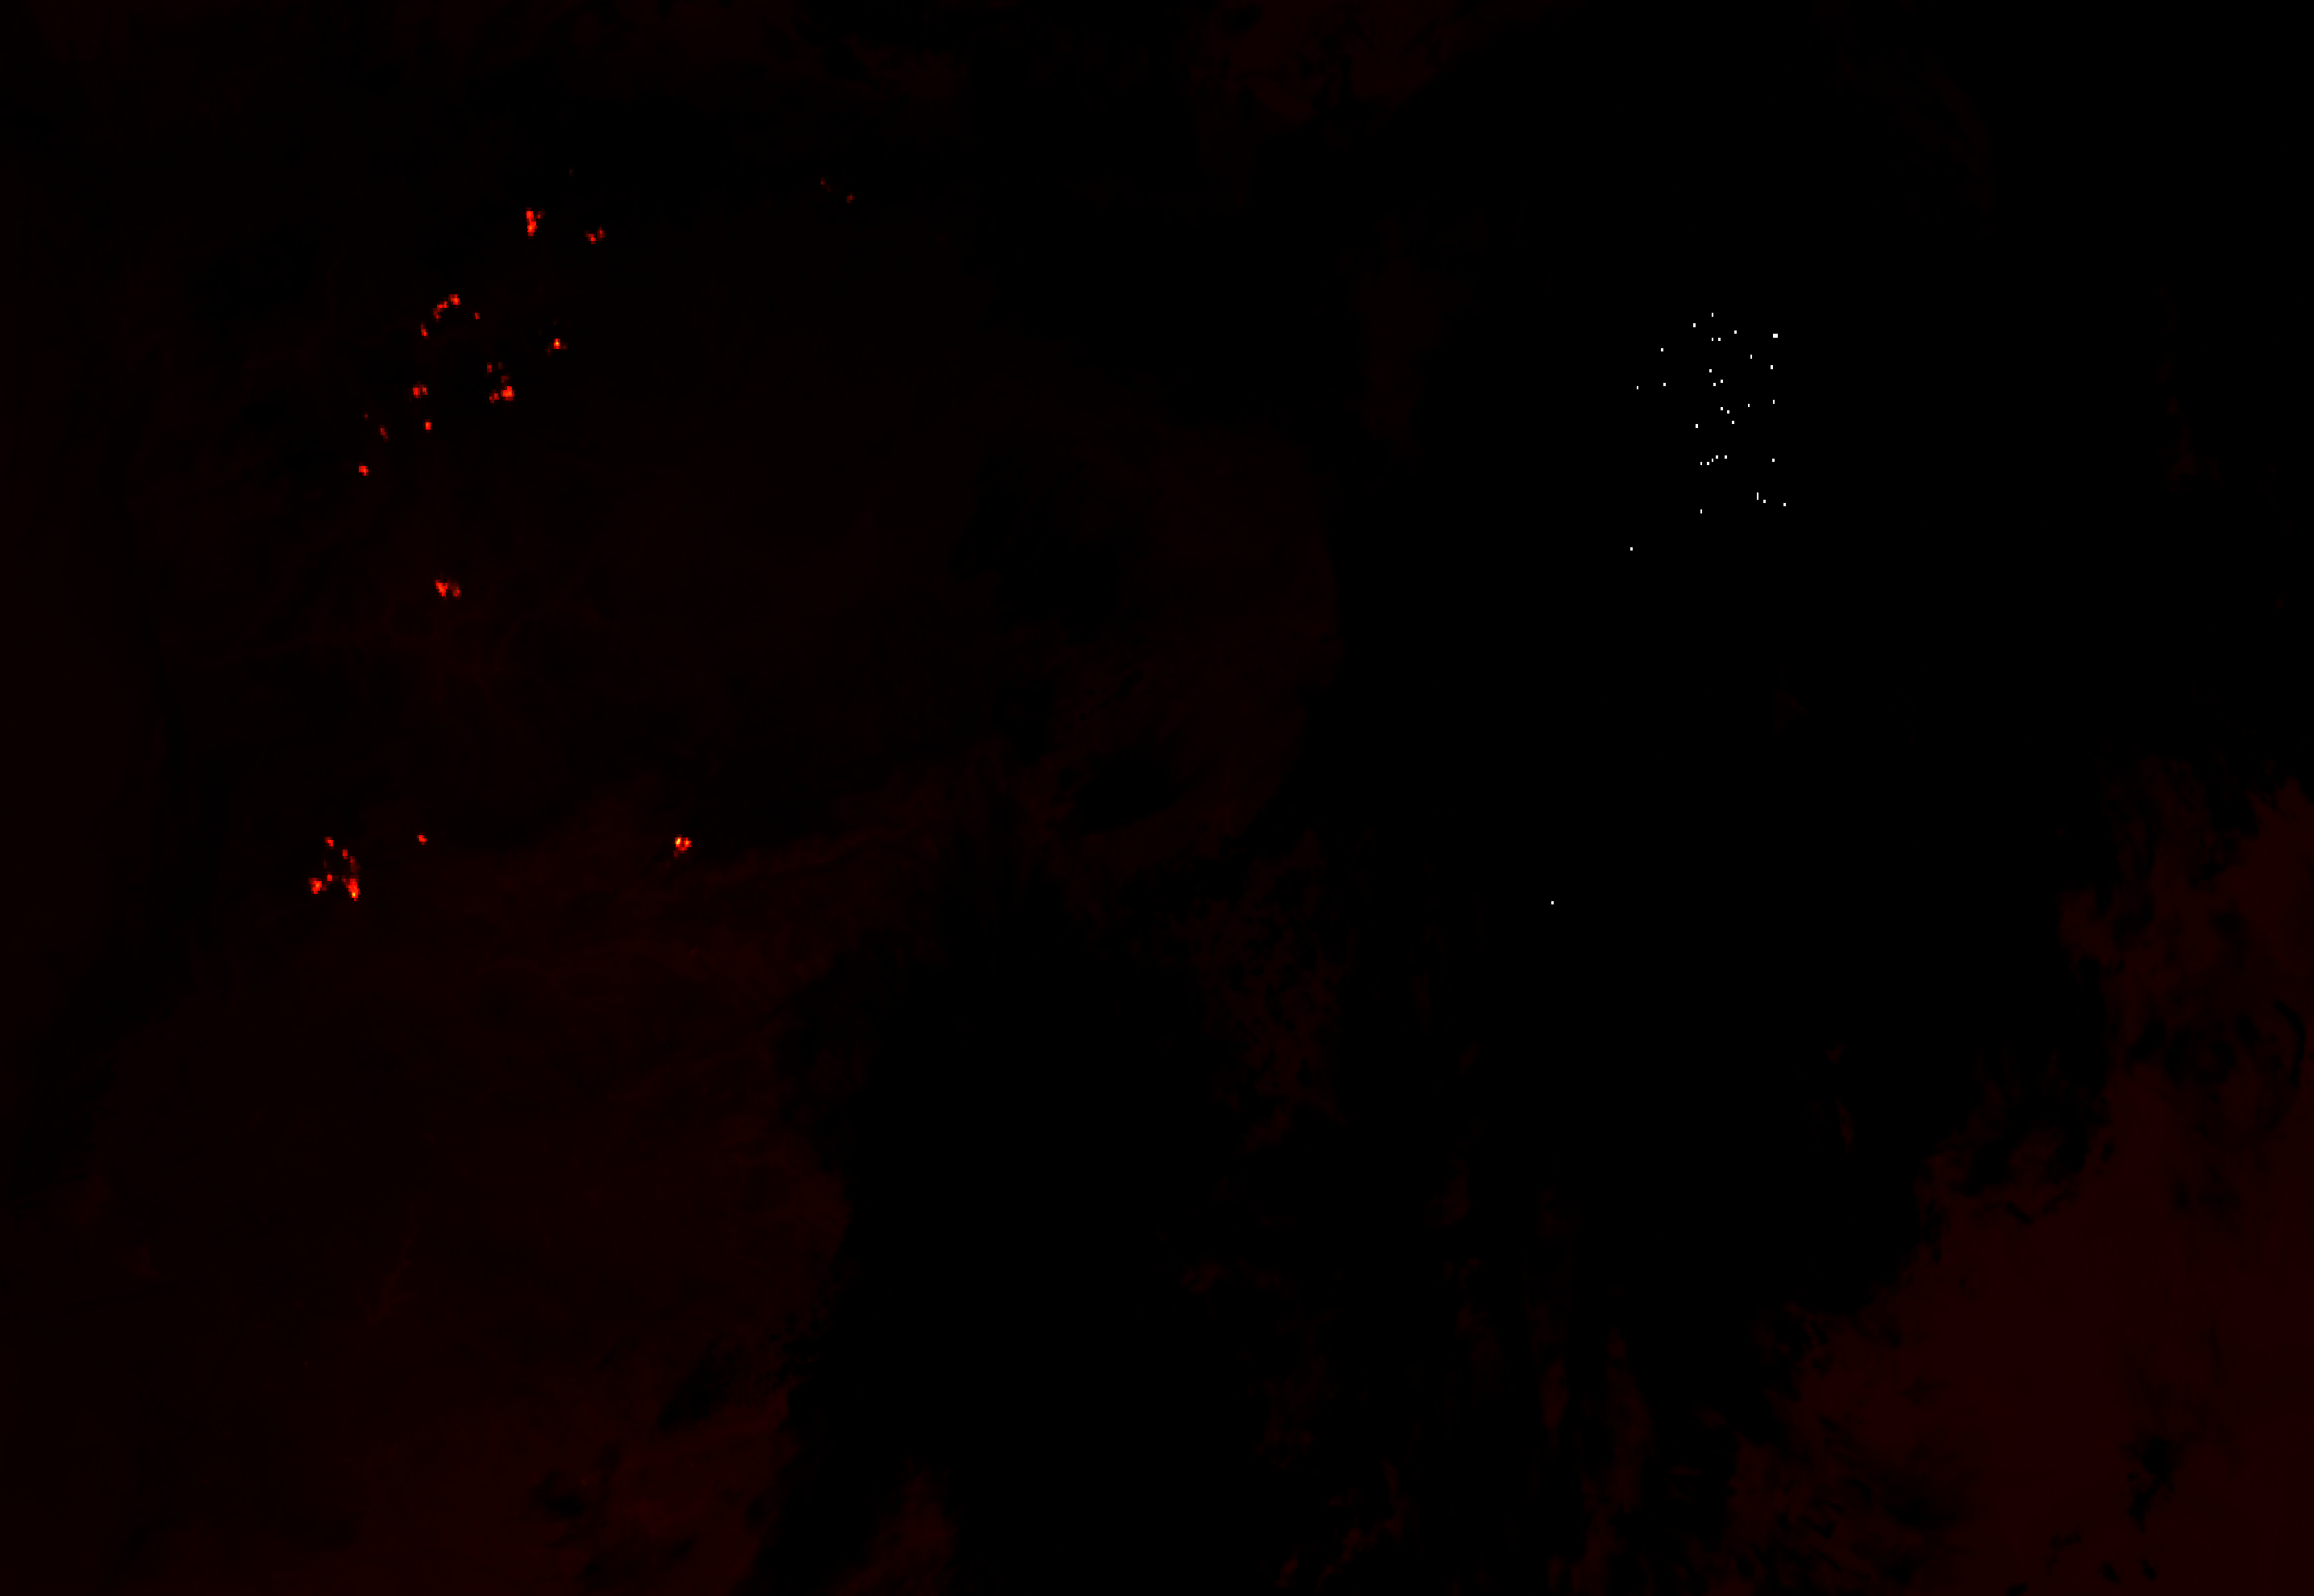

In [16]:
ch='fire_temperature'
scn.load([ch], upper_right_corner='NE', pad_data=False)

scn_resampled_temp = scn.resample(adef)
xr_temp = get_enhanced_image(scn_resampled_temp["fire_temperature"])
img2 = np.moveaxis(xr_temp.data.to_numpy(), 0, -1)

scn_resampled_temp.show(ch)

## 4 - Compare FIR data with RGB composites

Plots a 3-panel map for comparison of different data: fire probability heatmap, fire classification categories, and a normalized Satpy RGB scene.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


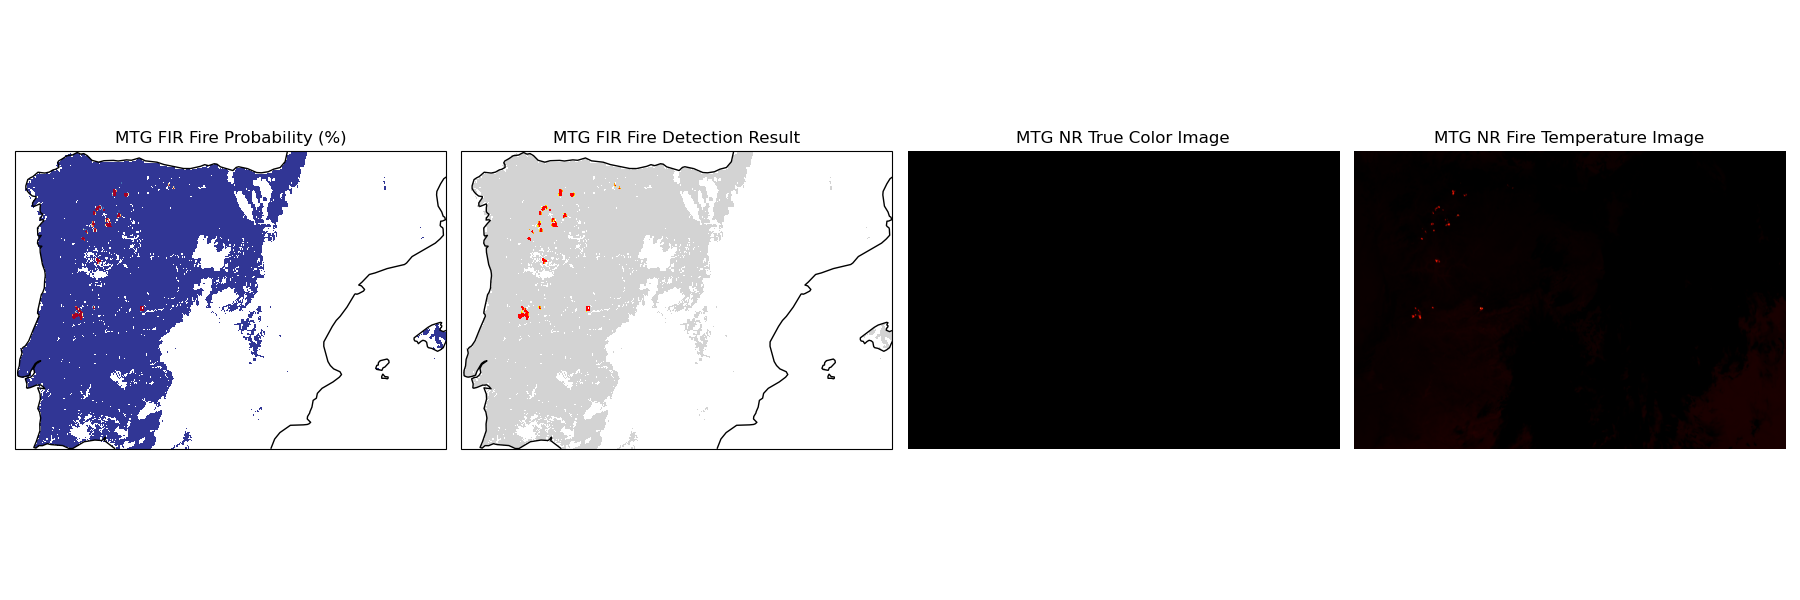

In [17]:
%matplotlib widget
# Define CRS
crs = adef.to_cartopy_crs()

# Prepare colormap
result_labels = {
    0: 'No fire',
    1: 'Fire low confidence',
    2: 'Fire medium confidence',
    3: 'Fire high confidence',
    4: 'Missing-undefined'
}
colors = ['lightgray', 'yellow', 'orange', 'red', 'white']
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(1, 4, subplot_kw={'projection': crs}, figsize=(18, 6))

# Fire probability map 
ax = axes[0]
ax.coastlines(resolution='50m')
im1 = ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r',
                extent=crs.bounds, origin='upper',
                vmin=0, vmax=100, interpolation='none')
ax.set_title("MTG FIR Fire Probability (%)")

# Fire classification result 
ax = axes[1]
ax.coastlines(resolution='50m')
im2 = ax.imshow(fir_res, transform=crs, cmap=cmap, norm=norm,
                extent=crs.bounds, origin='upper', interpolation='nearest')
ax.set_title("MTG FIR Fire Detection Result")

# Satpy scenes 
ax = axes[2]
ax.imshow(img, transform=crs, origin='upper')
ax.set_title("MTG NR True Color Image")

ax = axes[3]
ax.imshow(img2, transform=crs, origin='upper')

ax.set_title("MTG NR Fire Temperature Image")

plt.tight_layout()
plt.show()


## Load and visualise S3 NRT FRP product

In [18]:
search_bbox = ",".join([str(lonmin), str(latmin), str(lonmax), str(latmax)])
download_from_eumdac("2025-08-18T16:00:00", "2025-08-18T23:59:00", ["EO:EUM:DAT:0417"], file_endings,
                     lonlat_bbox, output_folder, run_name,
                     credentials.EUMDAC_CONSUMER_KEY, credentials.EUMDAC_CONSUMER_SECRET,
                     search_bbox=search_bbox)

[2025-09-19 15:20:06] [DEBUG] download_fci_from_archive: DataStore initialized.
[2025-09-19 15:20:06] [INFO] download_fci_from_archive: Searching for products in area -9.56,37.0,3.3322,43.7914
[2025-09-19 15:20:12] [INFO] download_fci_from_archive: Found 4 products for collection_id EO:EUM:DAT:0417 with type SL_2_FRP___ and time range 2025-08-18 16:00:01 to 2025-08-18 23:58:59 (adjusted for L2).
[2025-09-19 15:20:13] [INFO] download_fci_from_archive: File already exists, skipping download: products/S3B_SL_2_FRP____20250818T222627_20250818T223127_20250819T004819_0299_110_101______MAR_O_NR_003.SEN3/FRP_MWIR1km_standard.nc
[2025-09-19 15:20:13] [INFO] download_fci_from_archive: File already exists, skipping download: products/S3B_SL_2_FRP____20250818T222627_20250818T223127_20250819T004819_0299_110_101______MAR_O_NR_003.SEN3/FRP_Merged_MWIR1kmStandard_SWIR1km.nc
[2025-09-19 15:20:13] [INFO] download_fci_from_archive: File already exists, skipping download: products/S3B_SL_2_FRP____20250818

In [19]:
# You can change the folder below
data_folder = 'S3B_SL_2_FRP____20250818T222627_20250818T223127_20250819T004819_0299_110_101______MAR_O_NR_003.SEN3'

frp_xr = xr.open_dataset(Path("./products/") / data_folder / "FRP_MWIR1km_standard.nc", engine='netcdf4')
frp_xr

<xarray.Dataset> Size: 12MB
Dimensions:                            (fires_MWIR1km_standard: 529,
                                        rows: 2000, columns: 1500)
Dimensions without coordinates: fires_MWIR1km_standard, rows, columns
Data variables: (12/36)
    i                                  (fires_MWIR1km_standard) int16 1kB ...
    j                                  (fires_MWIR1km_standard) int32 2kB ...
    time                               (fires_MWIR1km_standard) datetime64[ns] 4kB ...
    latitude                           (fires_MWIR1km_standard) float32 2kB ...
    longitude                          (fires_MWIR1km_standard) float32 2kB ...
    FRP_MWIR                           (fires_MWIR1km_standard) float32 2kB ...
    ...                                 ...
    sat_zenith                         (fires_MWIR1km_standard) float32 2kB ...
    sat_azimuth                        (fires_MWIR1km_standard) float32 2kB ...
    eff_across_track_pixel_size        (fires_MWIR1km_standard) float32 2kB ...
    eff_along_track_pixel_size         (fires_MWIR1km_standard) float32 2kB ...
    convert_f3                         (fires_MWIR1km_standard) uint8 529B ...
    flags                              (rows, columns) uint32 12MB ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jun 13 2024 12:58:03 $
    product_name:           S3B_SL_2_FRP____20250818T222627_20250818T223127_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 04.03
    ...                     ...
    absolute_orbit_number:  38103
    start_time:             2025-08-18T22:26:26.858467Z
    stop_time:              2025-08-18T22:31:26.848197Z
    processing_baseline:    FRP_NRT.003.01.00
    track_offset:           998
    start_offset:           3008

In [20]:
lat_frp = frp_xr['latitude']
lon_frp = frp_xr['longitude']
frp_val = frp_xr['FRP_MWIR']

frp_values = frp_val.values

np.max(frp_values)


671.7116

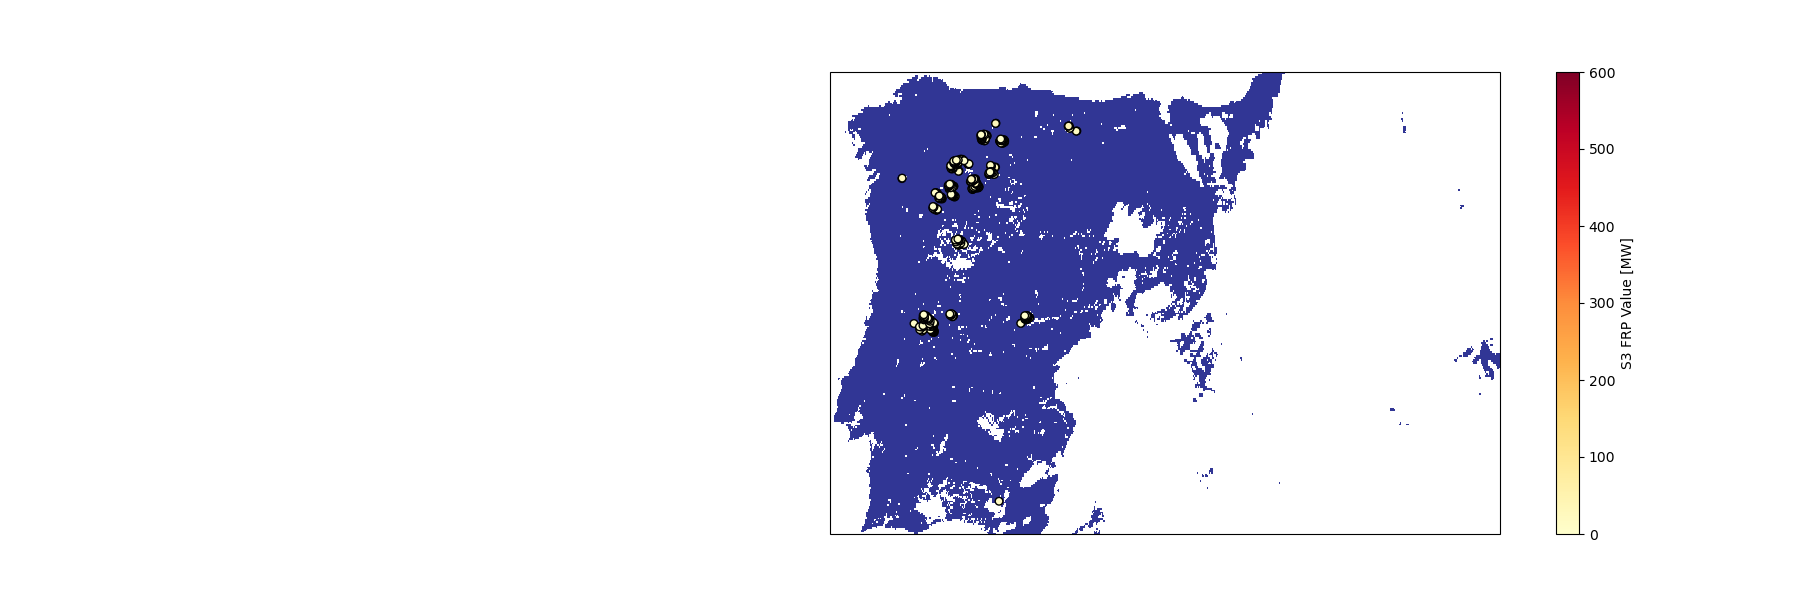

In [21]:
from matplotlib import cm

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': crs}, figsize=(18, 6))

im1 = ax.imshow(fir_prob.values*100, transform=crs, cmap='RdYlBu_r',
                extent=crs.bounds, origin='upper',
                vmin=0, vmax=100, interpolation='none')

scatter = ax.scatter(
    lon_frp.values, lat_frp.values,
    c=frp_val,
    cmap='YlOrRd',
    s=30,  # size of markers
    edgecolor='black',  # optional: add a black border around markers
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=600
)

colormap = cm.ScalarMappable(cmap='YlOrRd')
colormap.set_clim(0, 600)
cbar = plt.colorbar(colormap, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('S3 FRP Value [MW]')



<hr>

References:
* https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store/-/blob/master/1_5_MTG_FCI_data_access.ipynb
* https://www.eumetrain.org/resources/andrea-meraner-eumetsat-fci4fires-detecting-and-visualising-wildfires-mtg-fci (slides)
* https://user.eumetsat.int/resources/user-guides/mtg-fci-l2-fir-data-guide#ID-Data-loading-analysis-processing-and-visualisation-tools

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE.TXT">GPL-3.0-or-later</a> </p>